In [1]:
import warnings
import pandas as pd
import numpy as np
import numpy.ma as ma
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def extract_post_burst(num_spikes, num_bursts, burst_end_mask, width, spike_count):
    """
    Extracts postburst spike sequences of specified duration.
    
    Args:
        num_spikes (int): total spike count in the simulation
        num_bursts (int): total number of bursts in the simulation
        burst_end_mask (boolean array): boolean array of size num_spikes, where each spike indicating the end of a burst
            is marked as True
        width (int): duration (=number of time steps) of the sequence to extract
        spike_count(2D array): 2d array containing spike counts foe each timestep
    
    Returns:
        post_burst(2D array): 2D array contaning postburts spike sequences of duration 
    """

    # initialize post_burst
    post_burst = np.zeros((num_bursts, width))
    index = 0
    
    for i in tqdm(range(num_spikes)):
        if burst_end_mask[i] and i + width + 1 < num_spikes:
            post_burst[index, 0:width] = spike_count[1][i+1:i+1+width]
            index += 1 
    
    if index < num_bursts:
        post_burst = np.delete(post_burst, np.s_[index:num_bursts], 0)
    
    return post_burst

In [3]:
def process_post_burst(post_burst, bin_size=100):
    """
    Processes postburst sequences.
    
    Args:
        post_burst (2D array): 2D array contaning postburts spike sequences of duration produced by extract_post_burst
        bin_size (int): size of the bin, 10 ms (=100 time steps) by default
    
    Returns:
        post_burst_mean (1d array): mean of the number of spikes per time step
        post_burst_std (1d array): standard deviation of the number of spikes per time step
        bins (2d array): binned postburst sequences 
        bins_mean (1d array): mean of the number of spikes per bin
        bins_std (1d array): mean of the number of spikes per bin
    """
    
    post_burst_mean = np.mean(post_burst, axis=0)
    post_burst_std = np.std(post_burst, axis=0)
    bins = np.add.reduceat(post_burst, np.arange(0, post_burst.shape[1], bin_size), axis=1)
    bins_mean = np.mean(bins, axis=0)
    bins_std = np.std(bins, axis=0)
    
    return post_burst_mean, post_burst_std, bins, bins_mean, bins_std

In [4]:
def plot_post_burst(post_burst, width, figsize, elw=0.1, binned=False, with_std=False):
    """
    Creates a plot of the postburst activity. Saves the plot as a png.
    
    Args:
        post_burst (2D array): 2D array contaning postburts spike sequences of duration produced by extract_post_burst
        width (int): duration of the postburst sequence
        figsize (tuple(int, int)): size of the plot, (width, height)
        elw (int): linewitdth of the errorbars
        binned (boolean): if True, plot binned postbursts
        with_std (Boolean): if True, plot standard deviation
    
    Returns:
        none
    """
    
    post_burst_mean, post_burst_std, bins, bins_mean, bins_std = process_post_burst(post_burst)
    
    plt.figure(figsize=figsize)
    
    if binned:
        plt.ylabel('Number of spikes per bin', fontsize=16)
        plt.xlabel('Bins',fontsize=16)
        plt.title('Postburst Spiking Activity (binned)\nsequence duation = ' + str(width) + 
              ' time steps\nbins = 10 ms (100 time steps)', fontsize=16)
    else:
        plt.ylabel('Number of spikes per time step',fontsize=16)
        plt.xlabel('Time steps', fontsize=16)
        plt.title('Postburst Spiking Activity\nsequence duation = ' + str(width) + 
              ' time steps', fontsize=16)
        
    if not binned and not with_std:
        plt.plot(post_burst_mean, color='k')
    
    if not binned and with_std:
        plt.errorbar(np.arange(post_burst_mean.shape[0]), post_burst_mean, post_burst_std, 
                     elinewidth=elw, color='k', ecolor='b')
    
    if binned and not with_std:
        plt.plot(bins_mean[:-1], color='k')
    
    if binned and with_std:
        plt.errorbar(np.arange(bins.shape[1]-1), bins_mean[:-1], yerr=bins_std[:-1], 
                     elinewidth=elw, color='k', ecolor='b')
        
    plt.show()

In [5]:
# load spike data
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    spikes = pd.read_csv('/home/NETID/lundvm/data/spikes.csv', index_col=0)
# load burst data
bursts = pd.read_csv('/home/NETID/lundvm/data/allBurst.csv')

In [6]:
# calculate ibi statistics 
min_ibi = min(bursts['IBI'].values[1:])
max_ibi = max(bursts['IBI'].values[1:])
ibi_mean = np.mean(bursts['IBI'].values[1:])
ibi_std = np.std(bursts['IBI'].values[1:])
#initialize variables
num_timesteps = 600000000 #known from the settings of the simulation
time_steps = np.arange(num_timesteps)
spike_count = np.vstack((time_steps, np.append(np.bincount(spikes['time_step'].values), np.array([0]))))
burst_end_mask = np.in1d(spike_count[0], bursts['EndT'].values)
# number of bursts
num_bursts = bursts['EndT'].values.shape[0]
# number of spikes
num_spikes = spike_count.shape[1]

In [7]:
print('Simulation statistics: ')
print('Length of the simulation: ' + str(num_timesteps) + ' timesteps')
print('Min IBI: ' + str(min_ibi) + ' timesteps')
print('Max IBI: ' + str(max_ibi) + ' timesteps')
print('Mean IBI: ' + str(round(ibi_mean, 2)) + ' timesteps, with standartd deviation of ' + str(round(ibi_std, 2)))
print('Number of bursts: ' + str(num_bursts))
print('Number of spikes: ' + str(num_spikes))

Simulation statistics: 
Length of the simulation: 600000000 timesteps
Min IBI: 5445 timesteps
Max IBI: 954063 timesteps
Mean IBI: 50257.91 timesteps, with standartd deviation of 35369.8
Number of bursts: 9729
Number of spikes: 600000000


In [8]:
# extract postburst sequences, duration = min_ibi
post_burst_min = extract_post_burst(num_spikes, num_bursts, burst_end_mask, min_ibi, spike_count)

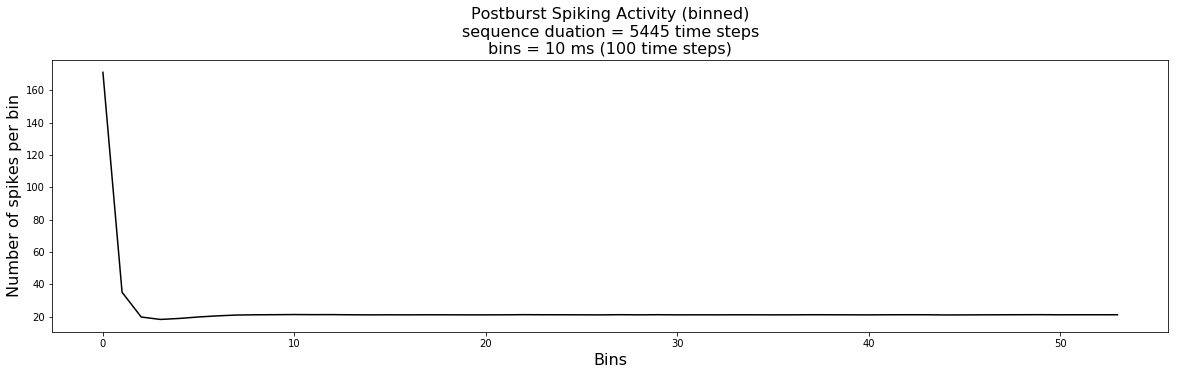

In [9]:
plot_post_burst(post_burst_min, min_ibi, (20, 5), binned=True)

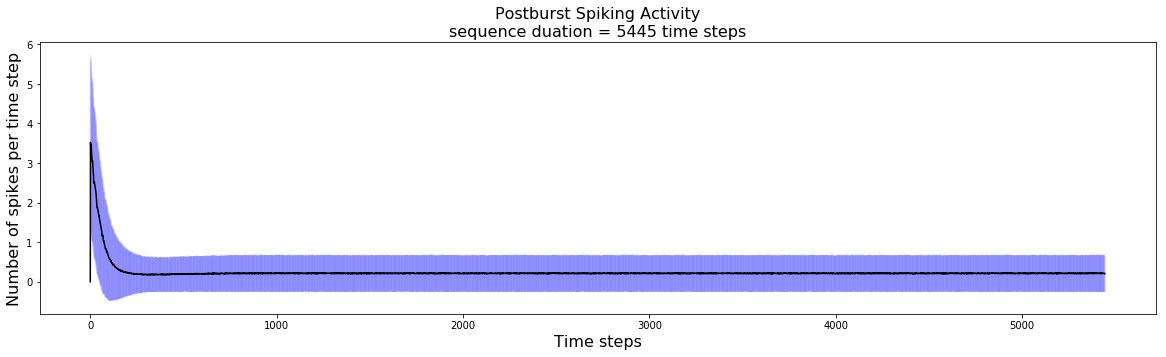

In [10]:
plot_post_burst(post_burst_min, min_ibi, (20, 5), binned=False, with_std=True)

In [11]:
post_burst_max = extract_post_burst(num_spikes, num_bursts, burst_end_mask, max_ibi, spike_count)

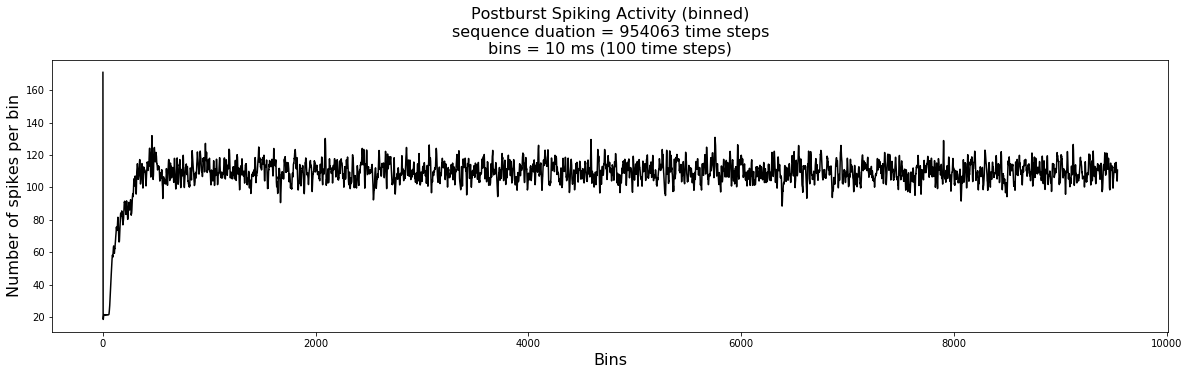

In [12]:
plot_post_burst(post_burst_max, max_ibi, (20, 5), binned=True)

In [13]:
post_burst_10k = extract_post_burst(num_spikes, num_bursts, burst_end_mask, 10000, spike_count)

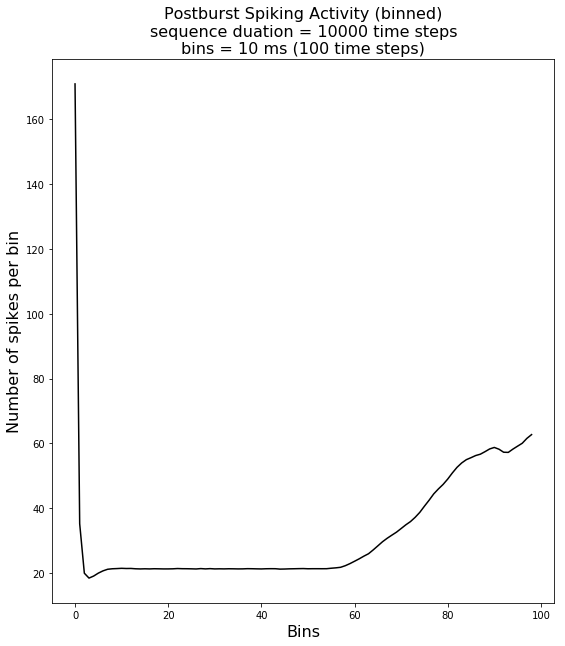

In [14]:
plot_post_burst(post_burst_10k, 10000, (9, 10), binned=True)

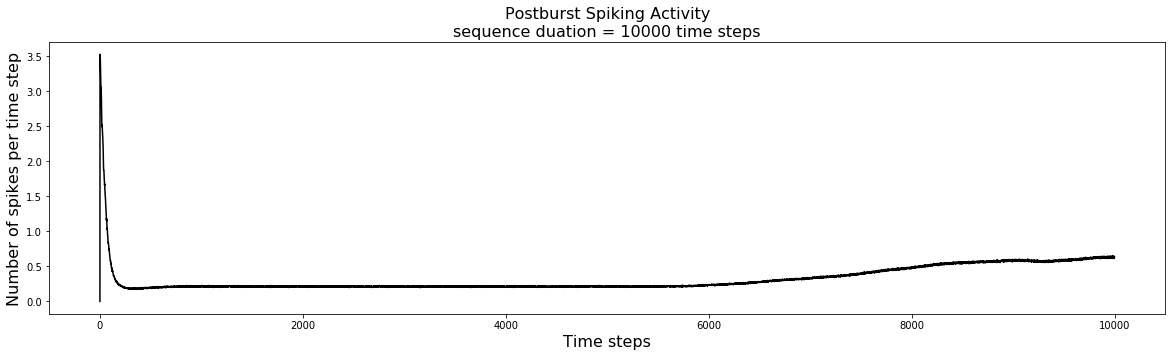

In [15]:
plot_post_burst(post_burst_10k, 10000, (20, 5))

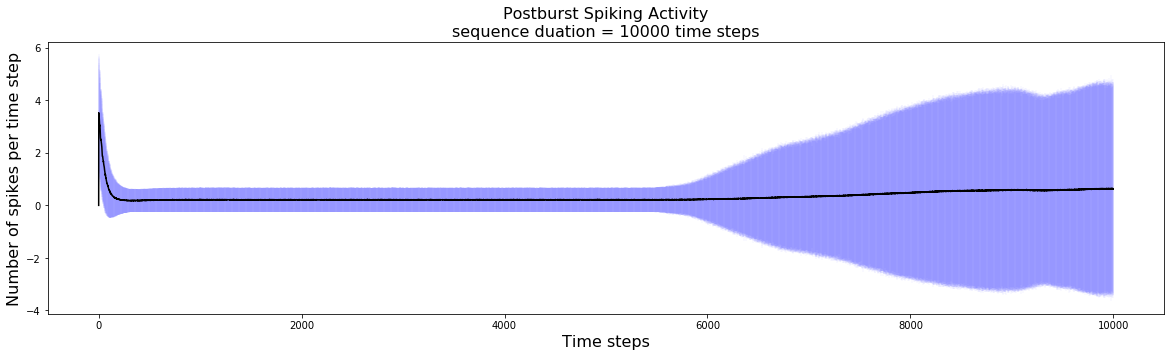

In [16]:
plot_post_burst(post_burst_10k, 10000, (20, 5), elw=0.05, with_std=True)

In [17]:
post_burst_10 = extract_post_burst(num_spikes, num_bursts, burst_end_mask, 10, spike_count)

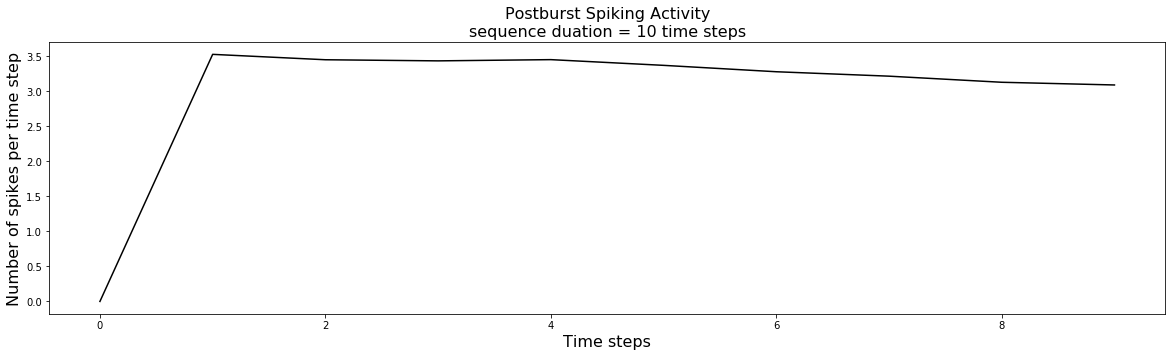

In [18]:
plot_post_burst(post_burst_10, 10, (20, 5))

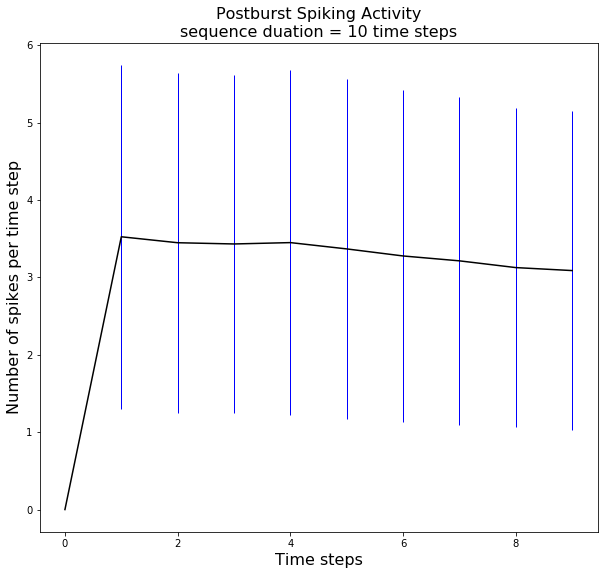

In [21]:
plot_post_burst(post_burst_10, 10, (10, 9), elw=1, with_std=True)